In [4]:
#Loading the necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn, jet, RdBu

import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

In [5]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
lower_left = (40.75,-74.01)
upper_right = (40.88,-73.86)

In [6]:
# Calculate the bounds for doing an archive data search
bounds = (lower_left[1],lower_left[0],upper_right[1],upper_right[0])

In [7]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [8]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox = bounds,
    datetime = time_window,
    collections = ['sentinel-2-l2a'],
    query = {'eo:cloud_cover': {"lt":30}},
)

items = list(search.get_items())
print("The number of scenes that touch our region are : ",len(items))

The number of scenes that touch our region are :  10


In [9]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [10]:
# Define the pixel resolution for the final product
resolution = 10 # meters per pixel

In [11]:
# Define the scale according to the selected CRS
scale = resolution / 11320.0 # degrees per pixel for crs = 4326

In [12]:
data = stac_load(
    items,
    bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12'],
    crs = "EPSG:4326",
    resolution = scale,
    chunks = {"x":2048,"y":2048},
    dtype = 'uint16',
    patch_url = planetary_computer.sign,
    bbox = bounds
)

In [13]:
display(data)

<xarray.Dataset> Size: 6MB
Dimensions:      (latitude: 148, longitude: 171, time: 10)
Coordinates:
  * latitude     (latitude) float64 1kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 1kB -74.01 -74.01 -74.01 ... -73.86 -73.86
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
    spatial_ref  int32 4B 4326
Data variables:
    B01          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 506kB dask.array<chunksize=(1, 148, 171), meta=np.ndarray>

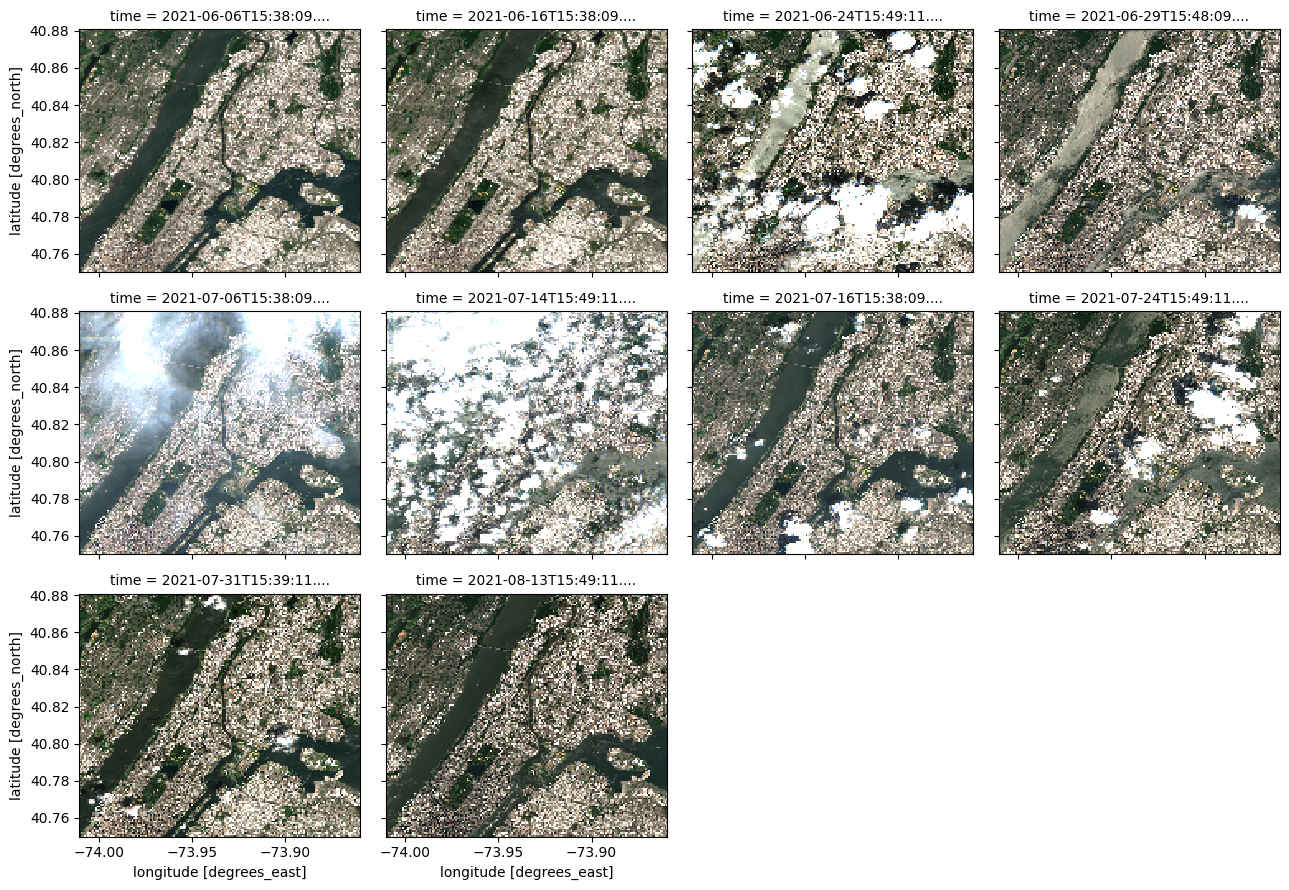

In [14]:
# Plot sample image from the time series
plot_data = data[['B04','B03','B02']].to_array()
plot_data.plot.imshow(col = 'time', col_wrap = 4, robust = True, vmin = 0, vmax = 2500)
plt.show()

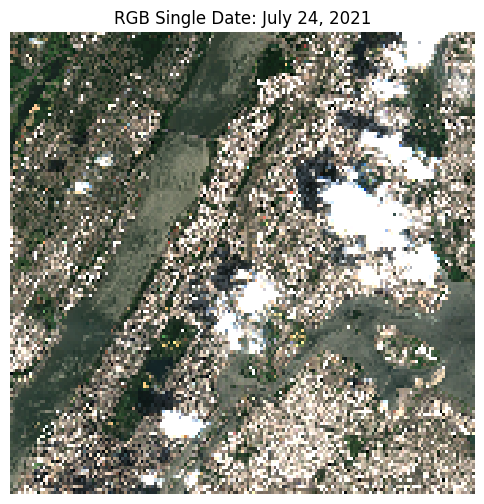

In [16]:
# Plot an RGB for a single date
fig, ax = plt.subplots(figsize = (6,6))
plot_data.isel(time = 7).plot.imshow(robust = True, ax = ax, vmin = 0, vmax = 2500)
ax.set_title("RGB Single Date: July 24, 2021")
ax.axis("off")
plt.show()

In [17]:
median = data.median(dim = 'time').compute()

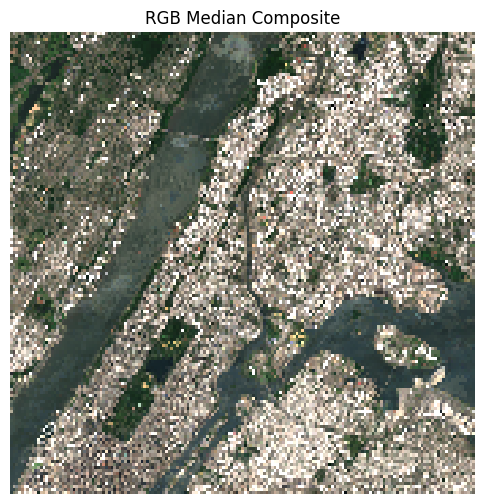

In [18]:
# Plot an RGB image for the median composite or mosaic

fig, ax = plt.subplots(figsize = (6,6))
median[["B04","B03","B02"]].to_array().plot.imshow(robust = True, ax=ax, vmin = 0, vmax = 2500)
ax.set_title("RGB Median Composite")
ax.axis("off")
plt.show()

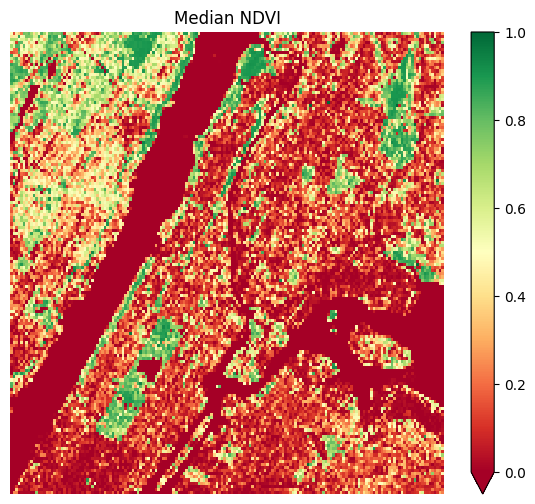

In [21]:
# Calculate the NDVI for the median mosaic
ndvi_median = (median.B08 - median.B04)/(median.B08 + median.B04)

fig,ax = plt.subplots(figsize = (7,6))
ndvi_median.plot.imshow(vmin = 0.0, vmax = 1.0, cmap = "RdYlGn")
ax.set_title("Median NDVI")
ax.axis("off")
plt.show()

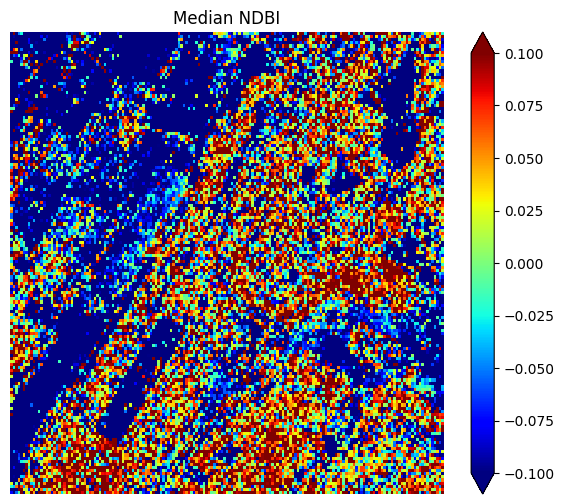

In [24]:
# Calculate the NDBI for the median mosaic
ndbi_median = (median.B11 - median.B08)/(median.B11 + median.B08)

fig,ax = plt.subplots(figsize = (7,6))
ndbi_median.plot.imshow(vmin = -0.1, vmax = 0.1, cmap = "jet")
ax.set_title("Median NDBI")
ax.axis("off")
plt.show()

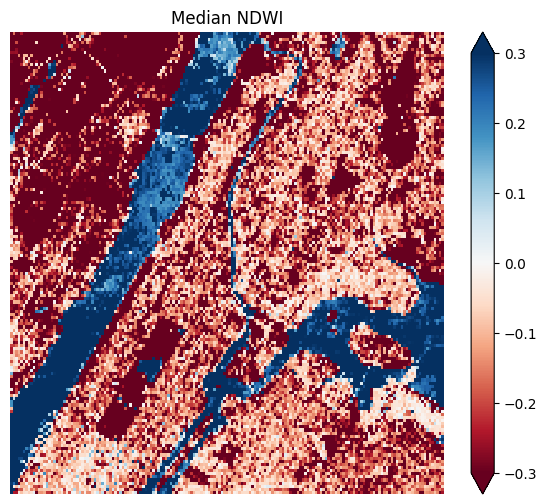

In [26]:
# Calculate the NDWI for the median mosaic
ndwi_median = (median.B03 - median.B08)/(median.B03 + median.B08)

fig,ax = plt.subplots(figsize = (7,6))
ndwi_median.plot.imshow(vmin = -0.3, vmax = 0.3, cmap = "RdBu")
ax.set_title("Median NDWI")
ax.axis("off")
plt.show()

In [27]:
filename = 'geotiff_image.tiff'

In [28]:
# Single time slice from the time series
data_slice = data.isel(time = 7)

In [29]:
# Calculate the dimensions of the file
height = data_slice.dims['latitude']
width = data_slice.dims['longitude']

In [30]:
# Define the CRS
gt = rasterio.transform.from_bounds(
    lower_left[1],
    lower_left[0],
    upper_right[1],
    upper_right[0],
    width,
    height)
data_slice.rio.write_crs("epsg:4326",inplace = True)
data_slice.rio.write_transform(transform = gt, inplace = True)

<xarray.Dataset> Size: 559kB
Dimensions:      (latitude: 148, longitude: 171)
Coordinates:
  * latitude     (latitude) float64 1kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 1kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    time         datetime64[ns] 8B 2021-07-24T15:49:11.024000
    spatial_ref  int64 8B 0
Data variables:
    B01          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B02          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B03          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B04          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B05          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B06          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B07          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B08          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B8A          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B11          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>
    B12          (latitude, longitude) uint16 51kB dask.array<chunksize=(148, 171), meta=np.ndarray>

In [33]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(
    filename,
    'w',
    driver = 'GTiff',
    width = width,
    height = height,
    crs = 'epsg:4326',
    transform = gt,
    count = 11,
    compress = 'lzw',
    dtype = 'float64') as dst:

    dst.write(data_slice.B01,1)
    dst.write(data_slice.B02,2)
    dst.write(data_slice.B03,3)
    dst.write(data_slice.B04,4)
    dst.write(data_slice.B05,5)
    dst.write(data_slice.B06,6)
    dst.write(data_slice.B07,7)
    dst.write(data_slice.B08,8)
    dst.write(data_slice.B8A,9)
    dst.write(data_slice.B11,10)
    dst.write(data_slice.B12,11)
    dst.close()